In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Preprocessing & Data Loading

In [3]:
def process_data(train_path, test_path):
    # Load data
    df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    # Map labels (ensure they match your schema)
    label_map = {0: "sadness", 1: "joy", 2: "love", 3: "anger", 4: "fear", 5: "surprise"}

    # Split training data into Train and Validation (to measure F1 before submitting)
    # We use 10% for validation to ensure we have enough data to test the >92% requirement
    train_df, val_df = train_test_split(df, test_size=0.1, stratify=df['emotions'], random_state=42)

    # Convert to Hugging Face Dataset format
    train_dataset = Dataset.from_pandas(train_df[['text', 'emotions']].rename(columns={'emotions': 'label'}))
    val_dataset = Dataset.from_pandas(val_df[['text', 'emotions']].rename(columns={'emotions': 'label'}))
    test_dataset = Dataset.from_pandas(test_df[['tweet_id', 'text']]) # Keep ID for submission

    return train_dataset, val_dataset, test_dataset, test_df

# Load and process
train_ds, val_ds, test_ds, test_df_original = process_data("train.csv", "test.csv")

# 2. Tokenization

In [4]:
MODEL_CKPT = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, max_length=128)

# Tokenize
tokenized_train = train_ds.map(tokenize_function, batched=True)
tokenized_val = val_ds.map(tokenize_function, batched=True)
tokenized_test = test_ds.map(tokenize_function, batched=True)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/348128 [00:00<?, ? examples/s]

Map:   0%|          | 0/38681 [00:00<?, ? examples/s]

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

# 3. Construction of the Model

In [6]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)

    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

# Initialize Model
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_CKPT,
    num_labels=6
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# 4. Training

In [8]:
# Training
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=3,              # 3 epochs is usually enough for BERT
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting training...")
trainer.train()

/tmp/ipython-input-4034393361.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

Starting training...
 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yanmuhan990731 (yanmuhan990731-city-university-of-hong-kong) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.094900,0.087501,0.941909,0.900949,0.946253,0.874810
2,0.083900,0.086857,0.944598,0.918192,0.906249,0.942163
3,0.077400,0.088689,0.943486,0.907683,0.929972,0.902796


TrainOutput(global_step=32637, training_loss=0.0979902509578351, metrics={'train_runtime': 3414.3014, 'train_samples_per_second': 305.885, 'train_steps_per_second': 9.559, 'total_flos': 2.8200400566253056e+16, 'train_loss': 0.0979902509578351, 'epoch': 3.0})

# 5. Validation

In [9]:
# Display Metrics
print("\nValidating best model...")
eval_results = trainer.evaluate()
print(f"Validation Macro F1: {eval_results['eval_f1']:.4f}")

# Detailed Report
preds_output = trainer.predict(tokenized_val)
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

print("\nClassification Report:")
target_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
print(classification_report(y_true, y_preds, target_names=target_names, digits=4))


Validating best model...


Validation Macro F1: 0.9182

Classification Report:
              precision    recall  f1-score   support

     sadness     0.9604    0.9971    0.9784     11246
         joy     0.9940    0.9242    0.9578     13092
        love     0.7810    0.9997    0.8769      3207
       anger     0.9515    0.9513    0.9514      5319
        fear     0.9948    0.8182    0.8979      4428
    surprise     0.7558    0.9626    0.8467      1389

    accuracy                         0.9446     38681
   macro avg     0.9062    0.9422    0.9182     38681
weighted avg     0.9523    0.9446    0.9454     38681



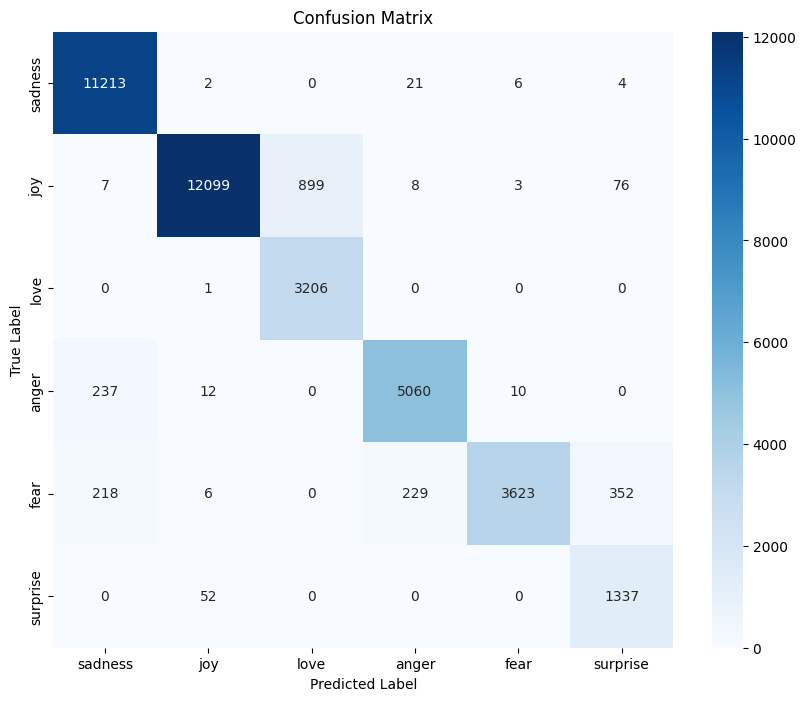

In [12]:
# Generate Confusion Matrix
cm = confusion_matrix(y_true, y_preds)

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names,
    yticklabels=target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# 6. Testing & Output

In [10]:
print("Generating predictions for test set...")
test_results = trainer.predict(tokenized_test)
test_preds = np.argmax(test_results.predictions, axis=1)

# Create submission file
submission = pd.DataFrame({
    'id': test_df_original['tweet_id'],
    'label': test_preds
})
submission.to_csv('sample_submission.csv', index=False)
print("Saved sample_submission.csv")

Generating predictions for test set...


Saved sample_submission.csv
